In [33]:
import kagglehub
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(f'{path}/healthcare-dataset-stroke-data.csv')

#Load dataset here


Path to dataset files: /home/emre/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


**Data summary**

Here we see a description of the data. We use functions such as `info()`,`describe()`,and `head()` to see the data summary. And after that we check the data for missing values.
 

In [34]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [35]:

df.describe()       #basic information about the data


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [36]:

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [37]:
print("Missing values:\n" , df.isnull().sum())

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


**Data balancing and handling missing values**

Previous section showed us that `bmi` attribute has a lot of missing values. To avoid training a model in a biased and incomplete dataset, we need to balance this attribute.
First we check the class imbalance on positive and negative cases on our target variable.

In [38]:
print("Stroke class balance: \n", df['stroke'].value_counts())


Stroke class balance: 
 stroke
0    4861
1     249
Name: count, dtype: int64


**Visualize the class imbalance**


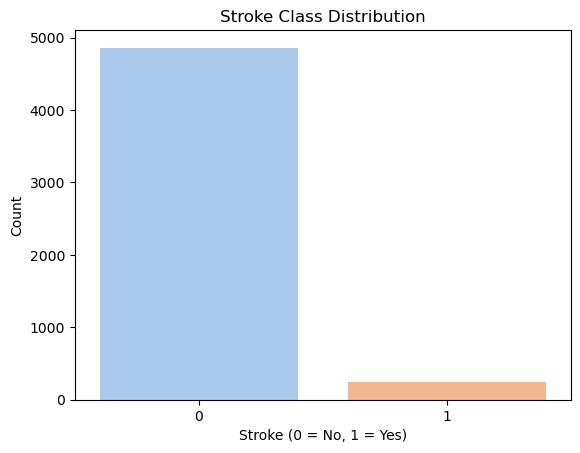

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='stroke', palette='pastel')
plt.title('Stroke Class Distribution')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


**Handling Nan values**

We are going to handle missing value in the `bmi` attribute using `Simple Imputer`. How I decided to handle these missing values is replacing Nan's with the median of that column.



In [40]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

imputer = SimpleImputer(strategy='median')
df['bmi'] = imputer.fit_transform(df[['bmi']])

**Pre-process other data**

Here we replace other in gender for simplicity sake. Then we label encode the binary columns such as `gender` , `ever_married`,and `residence_type`. Then we proceed to One-Hot Encode the multicategoricals. 

In [41]:
#Simplify
df['gender'] = df['gender'].replace('Other', 'Male')

#Label encode 
le = LabelEncoder()

for col in ['gender', 'ever_married', 'Residence_type']:
    df[col] = le.fit_transform(df[col])

#One-hot encode
df = pd.get_dummies(df, columns=['work_type','smoking_status'], drop_first=True)

#Drop ID
if 'id' in df.columns: 
    df = df.drop(columns=['id'])

**Test-train split**

First we would have to split the dataset into train-test splits. Then we are going to attempt to fix the class imbalance only on the train split.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis = 1), 
                                                    df['stroke'], 
                                                    test_size = 0.4, 
                                                    random_state = 42,
                                                    stratify=df['stroke'])

 Scale the dataset on both train and test sets.
    Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
    This prevents data leakage from test set to train set.


In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


**Balancing the data**

As we saw before the target variable is highly imbalanced. Now we are going to try out a few methods for handling this imbalance. Note that we will only do this on the training set.

**Random oversampling**

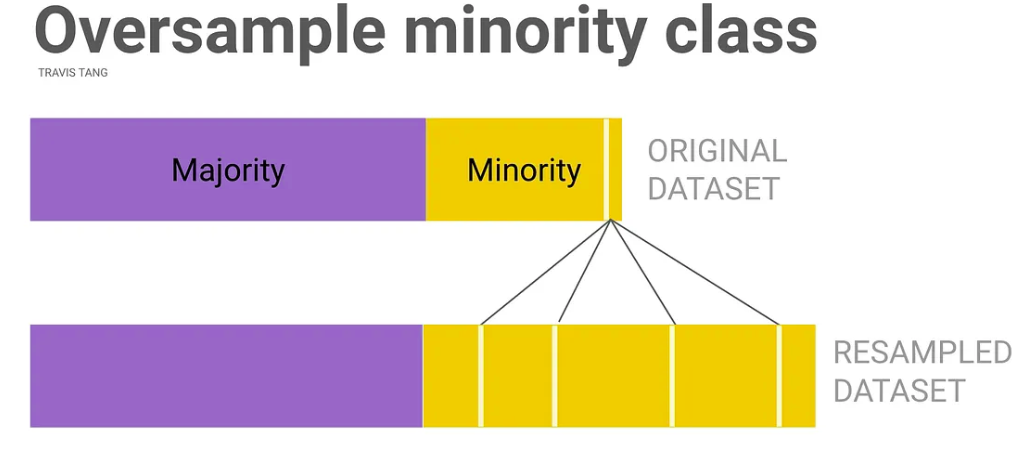

Output of the cell below will make the classes in `stroke` `0` and `1` equal. So while distribution of `df['stroke']` was,

 `stroke`

0    4861

1     249

After applying random oversampling, the minority class will `stroke=1` will be duplicated until it matches the number of samples in the majority class.

`stroke`

1    4861

0    4861

**Baseline Models**

These models use the data that is not oversampled.


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Train models
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
from imblearn.over_sampling import RandomOverSampler
X = df.drop(['stroke'] , axis=1)
Y = df['stroke']


# Perform random oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X,Y)

print(y_train_ros.value_counts())


stroke
1    4861
0    4861
Name: count, dtype: int64


In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, lr_pred))
print("Random Forest:\n", classification_report(y_test, rf_pred))
print('Accuracy (LR):', accuracy_score(y_test, lr_pred))
print('Accuracy (RF):', accuracy_score(y_test, rf_pred))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1944
           1       0.00      0.00      0.00       100

    accuracy                           0.95      2044
   macro avg       0.48      0.50      0.49      2044
weighted avg       0.90      0.95      0.93      2044

Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1944
           1       0.00      0.00      0.00       100

    accuracy                           0.95      2044
   macro avg       0.48      0.50      0.49      2044
weighted avg       0.90      0.95      0.93      2044

Accuracy (LR): 0.9510763209393346
Accuracy (RF): 0.9500978473581213


**Oversampled Data Model Training and Evaluation**

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Train models
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_ros, y_train_ros)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_ros, y_train_ros)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, lr_pred))
print("Random Forest:\n", classification_report(y_test, rf_pred))
print('Accuracy (LR):', accuracy_score(y_test, lr_pred))
print('Accuracy (RF):', accuracy_score(y_test, rf_pred))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1944
           1       0.00      0.00      0.00       100

    accuracy                           0.95      2044
   macro avg       0.48      0.50      0.49      2044
weighted avg       0.90      0.95      0.93      2044

Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1944
           1       0.00      0.00      0.00       100

    accuracy                           0.95      2044
   macro avg       0.48      0.50      0.49      2044
weighted avg       0.90      0.95      0.93      2044

Accuracy (LR): 0.9510763209393346
Accuracy (RF): 0.9510763209393346
